<a href="https://colab.research.google.com/github/Gurpreetkaur977/Gurpreet/blob/main/Student_performance_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving student_performance_200.csv to student_performance_200 (12).csv
Shape: (200, 10)


,Student_ID,Gender,Age,Parental_Education,Attendance_Rate,Math_Score,Reading_Score,Writing_Score,GPA,Final_Grade
0,1,Male,15,High School,80,3,9,24,12.00,Fail
1,2,Female,18,High School,95,9,4,89,34.00,Fail
2,3,Male,19,Bachelor,82,55,22,74,50.33,Fail
3,4,Male,18,PhD,75,16,9,37,20.67,Fail
4,5,Male,19,Associate,98,73,43,1,39.00,Fail



Basic descriptive stats:


,Student_ID,Gender,Age,Parental_Education,Attendance_Rate,Math_Score,Reading_Score,Writing_Score,GPA,Final_Grade
count,200.000000,200,200.000000,200,200.000000,200.000000,200.000000,200.000000,200.000000,200
unique,NaN,2,NaN,5,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Male,NaN,PhD,NaN,NaN,NaN,NaN,NaN,Fail
freq,NaN,100,NaN,44,NaN,NaN,NaN,NaN,NaN,142
mean,100.500000,NaN,16.875000,NaN,80.255000,48.485000,47.180000,50.490000,48.718350,NaN
std,57.879185,NaN,1.410433,NaN,11.991621,30.583928,28.850465,29.832698,17.437025,NaN
min,1.000000,NaN,15.000000,NaN,60.000000,0.000000,0.000000,0.000000,7.000000,NaN
25%,50.750000,NaN,15.000000,NaN,70.000000,21.000000,24.750000,25.750000,36.832500,NaN
50%,100.500000,NaN,17.000000,NaN,80.000000,50.000000,45.000000,50.000000,48.000000,NaN
75%,150.250000,NaN,18.000000,NaN,91.000000,74.000000,71.000000,80.000000,61.330000,NaN


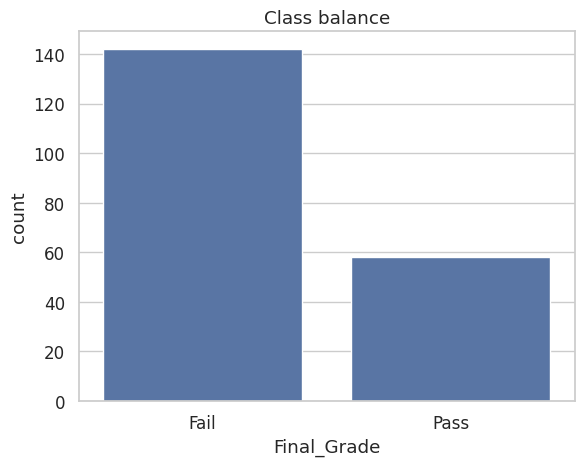

📈 Classification Metrics
Accuracy : 0.9

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        36
           1       0.80      0.86      0.83        14

    accuracy                           0.90        50
   macro avg       0.87      0.89      0.88        50
weighted avg       0.90      0.90      0.90        50



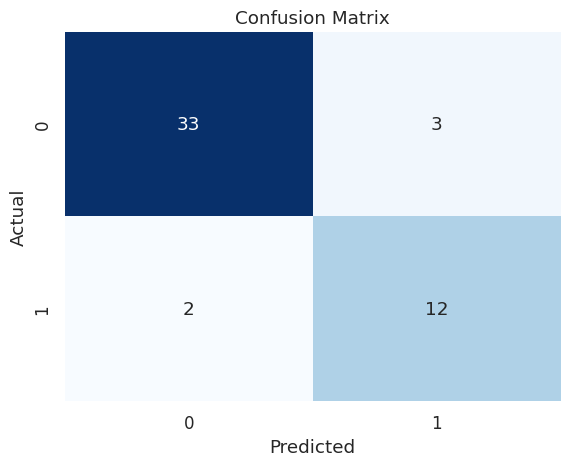

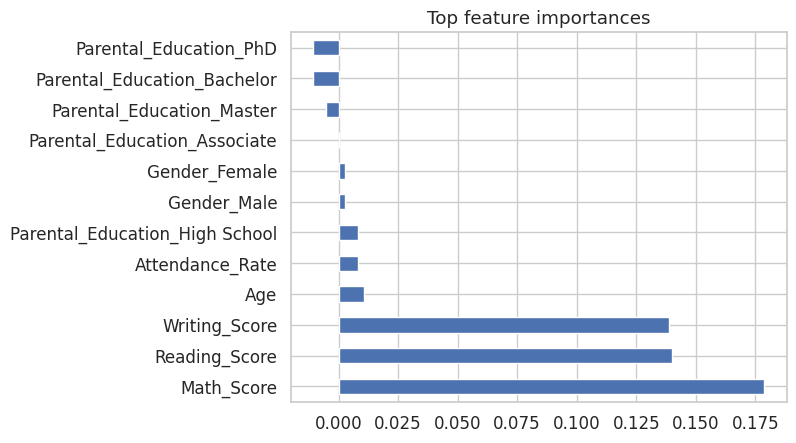


📈 Regression Metrics (GPA)
MAE : 2.791
R²  : 0.961


,Student_ID,Pred_Pass_Prob,Pred_GPA
0,1,0.01,14.66
1,2,0.10,35.07
2,3,0.04,49.40
3,4,0.00,21.05
4,5,0.07,40.62


In [22]:
# 🟢 1. SET-UP ──────────────────────────────────────────────────────────────
# ▸ Option A – upload file manually each session
from google.colab import files
uploaded = files.upload()   # choose student_performance_200.csv

# ▸ Option B – pull from your Google Drive (skip if using Option A)
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = '/content/drive/MyDrive/student_performance_200.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, r2_score
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings, pprint, itertools
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", font_scale=1.1)

# Read the CSV (from whichever route you chose)
DATA_PATH = next(iter(uploaded)) if 'uploaded' in locals() else (DATA_PATH)
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

# 🟠 2. QUICK EDA ───────────────────────────────────────────────────────────
print("\nBasic descriptive stats:")
display(df.describe(include='all'))

# Distribution of scores
# score_cols = ['Math_Score', 'Reading_Score', 'Writing_Score', 'GPA'] # These columns are not in the dataset
# df[score_cols].hist(figsize=(10, 6)) # Removed as score_cols not found
# plt.tight_layout(); plt.show() # Removed as score_cols not found

# Correlation heat-map
# plt.figure(figsize=(8, 6)) # Removed as score_cols not found
# sns.heatmap(df[score_cols].corr(), annot=True, fmt=".2f", square=True, # Removed as score_cols not found
#             cbar_kws={"shrink": .8}) # Removed as score_cols not found
# plt.title("Score correlations"); plt.show() # Removed as score_cols not found

# Pass/Fail balance
sns.countplot(x='Final_Grade', data=df)
plt.title("Class balance"); plt.show()

# 🟡 3. PRE-PROCESSING PIPELINE ─────────────────────────────────────────────
target_clf   = 'Final_Grade'   # classification label
target_regr  = 'GPA'           # regression target (optional)

# ▶ Features: drop targets + Student_ID (pure identifier)
X = df.drop([target_clf, target_regr, 'Student_ID'], axis=1)
y_clf = df[target_clf].map({'Fail':0, 'Pass':1})  # binary encode

# Identify column types
num_cols  = ['Age', 'Attendance_Rate', 'Math_Score', 'Reading_Score', 'Writing_Score']
cat_cols  = X.columns.difference(num_cols)

# Preprocessor
numeric_tf   = Pipeline([('sc', StandardScaler())])
categorical_tf = Pipeline([('oh', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categorical_tf, cat_cols)
    ])

# 🟢 4. CLASSIFICATION MODEL ───────────────────────────────────────────────
clf_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.25, stratify=y_clf, random_state=42)

clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print("📈 Classification Metrics")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy :", round(accuracy, 3))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

# Feature importance (via permutation)
from sklearn.inspection import permutation_importance

# Transform X_test using the fitted preprocessor
X_test_transformed = clf_pipeline.named_steps['prep'].transform(X_test)

# Get feature names after preprocessing
feature_names = []
for name, transformer, columns in clf_pipeline.named_steps['prep'].transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    elif hasattr(transformer, 'get_feature_names'):
         feature_names.extend(transformer.get_feature_names(columns))
    else:
        feature_names.extend(columns)


perm = permutation_importance(
    clf_pipeline.named_steps['model'], X_test_transformed, y_test, n_repeats=15, random_state=42, n_jobs=-1)
importances = pd.Series(
    perm.importances_mean,
    index=feature_names)
importances.nlargest(15).plot(kind='barh')
plt.title("Top feature importances"); plt.show()

# 🟣 5. REGRESSION MODEL (OPTIONAL GPA) ─────────────────────────────────────
# Predict GPA as continuous outcome
y_regr = df[target_regr]

regr_pipeline = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=400, max_depth=None, random_state=42))
])

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_regr, test_size=0.25, random_state=42)

regr_pipeline.fit(X_train_r, y_train_r)
y_pred_r = regr_pipeline.predict(X_test_r)

print("\n📈 Regression Metrics (GPA)")
print("MAE :", round(mean_absolute_error(y_test_r, y_pred_r), 3))
print("R²  :", round(r2_score(y_test_r, y_pred_r), 3))

# 🟤 6. PREDICT ON NEW DATA ────────────────────────────────────────────────
# Example: take first five students from the dataset, drop targets, predict outcomes
sample = X.head(5)
pred_pass_prob = clf_pipeline.predict_proba(sample)[:, 1]
pred_gpa = regr_pipeline.predict(sample)

display(pd.DataFrame({
    'Student_ID': df.loc[:4, 'Student_ID'],
    'Pred_Pass_Prob': pred_pass_prob.round(2),
    'Pred_GPA': pred_gpa.round(2)
}))